# TF-MoDISco on the TAL GATA simulation

This notebook demonstrates running TF-MoDISco on importance scores obtained from the TAL-GATA simulation used in the DeepLIFT paper. See `Generate Importance Scores.ipynb` for a notebook demonstrating how to produce the scores. There are 3 tasks. Task 0 is positive when both TAL and GATA motifs are present in the sequence. Task 1 is positive when GATA motifs are present in the sequence. Task 2 is positive when TAL motifs are present in the sequence.

In [1]:
from __future__ import print_function, division
%matplotlib inline

try:
    reload  # Python 2.7
except NameError:
    try:
        from importlib import reload  # Python 3.4+
    except ImportError:
        from imp import reload  # Python 3.0 - 3.3

In [2]:
import numpy as np
import modisco
import sys
print (sys.version)
import os
#os.environ["CUDA_VISIBLE_DEVICES"] = "4"

Couldn't import dot_parser, loading of dot files will not be possible.
2.7.12 |Anaconda 2.1.0 (x86_64)| (default, Jul  2 2016, 17:43:17) 
[GCC 4.2.1 (Based on Apple Inc. build 5658) (LLVM build 2336.11.00)]


TF-MoDISco is using the TensorFlow backend.


## Grab the input data

In [3]:
!./grab_scores_for_modisco.sh

File scores.h5 exists already
File sequences.simdata.gz exists already
File test.txt.gz exists already


### Functions for one-hot encoding sequences

In [4]:
import gzip

def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence),4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(zeros_array=to_return,
                                 sequence=sequence, one_hot_axis=1)
    return to_return

def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis==0 or one_hot_axis==1
    if (one_hot_axis==0):
        assert zeros_array.shape[1] == len(sequence)
    elif (one_hot_axis==1): 
        assert zeros_array.shape[0] == len(sequence)
    #will mutate zeros_array
    for (i,char) in enumerate(sequence):
        if (char=="A" or char=="a"):
            char_idx = 0
        elif (char=="C" or char=="c"):
            char_idx = 1
        elif (char=="G" or char=="g"):
            char_idx = 2
        elif (char=="T" or char=="t"):
            char_idx = 3
        elif (char=="N" or char=="n"):
            continue #leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: "+str(char))
        if (one_hot_axis==0):
            zeros_array[char_idx,i] = 1
        elif (one_hot_axis==1):
            zeros_array[i,char_idx] = 1

#read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz","rb")
ids_to_load = set([x.rstrip() for x in test_ids_fh])

fasta_sequences = []
for i,a_line in enumerate(gzip.open("sequences.simdata.gz","rb")):
    if (i==0):
        next
    a_line = a_line.rstrip()
    seq_id,seq_fasta,embeddings,task1,task2,task3 = a_line.split(b"\t")
    if seq_id in ids_to_load:
        fasta_sequences.append(seq_fasta.decode("utf-8"))

## Prepare the data for input into TF-MoDISCo

You need a numpy array of importance scores and hypothetical importance scores for every task.

In [5]:
import h5py
from collections import OrderedDict

task_to_scores = OrderedDict()
task_to_hyp_scores = OrderedDict()

f = h5py.File("scores.h5","r")
tasks = f["contrib_scores"].keys()
for task in tasks:
    #Note that the sequences can be of variable lengths;
    #in this example they all have the same length (200bp) but that is
    #not necessary.
    task_to_scores[task] = [np.array(x) for x in f['contrib_scores'][task][:]]
    task_to_hyp_scores[task] = [np.array(x) for x in f['hyp_contrib_scores'][task][:]]

onehot_data = [one_hot_encode_along_channel_axis(seq) for seq in fasta_sequences]

Double check by plotting

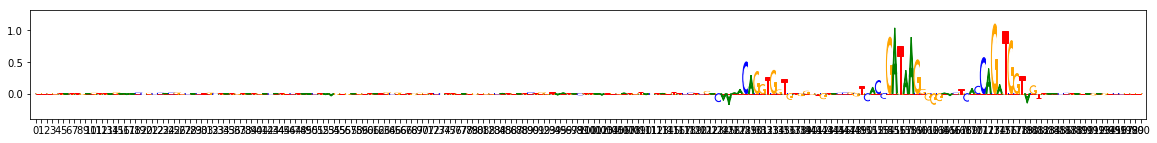

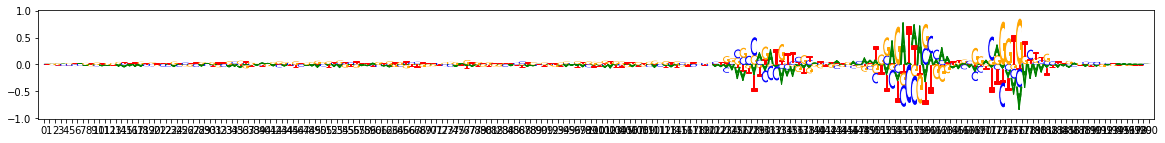

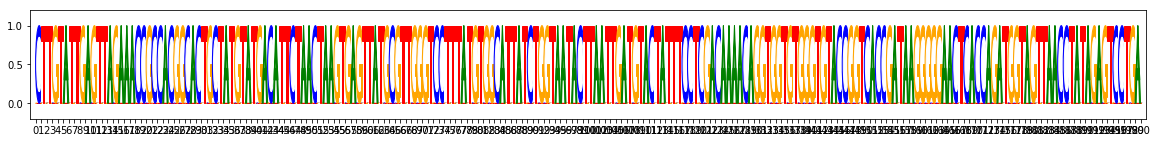

In [6]:
import modisco.visualization
from modisco.visualization import viz_sequence

viz_sequence.plot_weights(task_to_scores['task0'][0])
viz_sequence.plot_weights(task_to_hyp_scores['task0'][0])
viz_sequence.plot_weights(onehot_data[0])

## Run TF-MoDISco

TF-MoDISco first identifies seqlets, then splits the seqlets into "metaclusters" according to their pattern of activity across all the tasks, and then performs clustering within each task. Since there are 3 tasks, there are 27 possible metaclusters (consisting of a +1, -1 or 0 for each task). Consistent with the simulation, the [+1, +1, 0], [+1, 0, +1], [0, 0, +1] and [0, +1, 0] metaclusters turn up motifs.

To demonstrate customization, the code below has slight modifications from default settings in the following ways:
- Because the TAL and GATA motifs are relatively short compared to something like CTCF, it uses a sliding window size of 15 (rather than the default of 21) and flanks of 5 (rather than the default of 10). The sliding window size and flanks should be adjusted according to the expected length of the core motif and its flanks. If the window size or flank sizes are too long, you risk picking up more noise.
- During the seqlet clustering, motifs are trimmed to the central `trim_to_window_size` bp with the highest importance. `trim_to_window_size` is set to 10 rather than the default of 30. After the trimming is done, the seqlet is expanded on either side by `initial_flank_to_add`. This is set to 3 rather than the default of 10.
- The `final_min_cluster_size` is set to 60 rather than the default of 30. This is used to filter out small clusters with relatively weak support (in this case, fewer than 50 seqlets).
- It uses kmers of length 5 with 1 gap and no mismatches to compute the "quick and dirty" affinity matrix across all seqlets. The "quick and dirty" affinity matrix is used both for noise filtering and as a first pass to speed up computation of the continuous jaccard affinity matrix (the latter affinities are only computed between seqlets deemed to be close together by the "quick and dirty" method). I made the kmer length smaller to keep memory usage on the GPU down when testing on my macbook pro. The default is to use kmers of length 8 with 3 gaps and 2 mismatches, and this works fine on more modern GPUs than the one in my 4-year-old macbook.
- `target_seqlet_fdr` controls the noisiness of the seqelts. For a particular task, "significant" seqlets are identified by fitting a laplace distribution to the left and right tails of the values obtained after smoothing the importance scores with a window of size `sliding_window_size`. This laplace distribution is assumed to represent the null distribution of random seqlet importance scores. A threshold is then identified such that the false discovery rate (computed as the ratio of the expected number of seqlets according to the laplace null to the observed number of seqlets above the threshold) is less that `target_seqlet_fdr`. This is what is meant by "Est. FDR" printed in the logs below. If "Est. FDR" is above the target threshold, that means there was no significant increase in the number of seqlets relative to the null. You'll see below that "Est. FDR" for negative scores for any task is above this threshold, which fits with the simulation because there were no "negative set" motifs.

On task task0
Generating null dist
Computing windowed sums
Computing threshold
peak(mu)= -0.024238264271989465
Mu: -2.423826e-02 +/- 5.063778e-06
Lablace_b: 0.15164182366673082 and 0.21323786117475912
Thresholds: -1.5073591825459152 and 1.2725672367122025
#fdrs pass: 0 and 19793
CDFs: 0.999943452031181 and 0.9977152471273854
Est. FDRs: 1.0 and 0.00999113540721059


TF-MoDISco is using the TensorFlow backend.


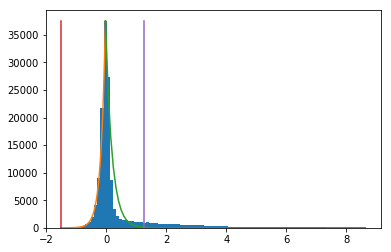

Got 1371 coords
On task task1
Generating null dist
Computing windowed sums
Computing threshold
peak(mu)= 0.005545238786377013
Mu: 5.545239e-03 +/- 5.741705e-06
Lablace_b: 0.1412717956920302 and 0.11624143409064712
Thresholds: -1.7306354243224487 and 0.7122924130493775
#fdrs pass: 0 and 15512
CDFs: 0.9999954008918504 and 0.9977118086817763
Est. FDRs: 0.3727485624294786 and 0.009994167375583403


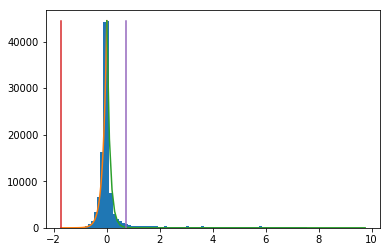

Got 1069 coords
On task task2
Generating null dist
Computing windowed sums
Computing threshold
peak(mu)= -0.011790548293385654
Mu: -1.179055e-02 +/- 7.010704e-06
Lablace_b: 0.1150758068659872 and 0.12597872040434585
Thresholds: -1.625360642401967 and 0.7686457290961407
#fdrs pass: 0 and 16462
CDFs: 0.9999991864034751 and 0.9979603661115659
Est. FDRs: 0.05563206652232111 and 0.009964247323977026


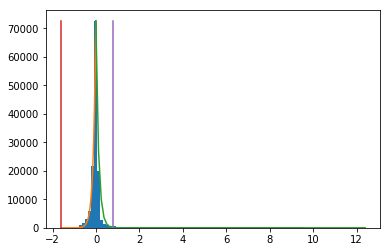

Got 1009 coords
After resolving overlaps, got 1966 seqlets
Across all tasks, the weakest transformed threshold used was: 0.9977117086817764
1966 identified in total
4 activity patterns with support >= 100 out of 27 possible patterns
Metacluster sizes:  [823, 668, 317, 158]
Idx to activities:  {0: '1,0,1', 1: '1,1,0', 2: '0,1,0', 3: '0,0,1'}
On metacluster 3
Metacluster size 158
Relevant tasks:  ('task2',)
Relevant signs:  (1,)
TfModiscoSeqletsToPatternsFactory: seed=1234
(Round 1) num seqlets: 158
(Round 1) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.05 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 1) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 1) Computing affinity matrix on nearest n

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.7s finished
/Users/avantishrikumar/Research/modisco/modisco/core.py:872: RuntimeWarning: invalid value encountered in true_divide
  return Snippet(fwd=self._track_name_to_agg[track_name]


Skipped 3 seqlets
Aggregating for cluster 1 with 30 seqlets
Trimmed 3 out of 30
Skipped 3 seqlets
Aggregating for cluster 2 with 24 seqlets
Trimmed 1 out of 24
Skipped 3 seqlets
Aggregating for cluster 3 with 20 seqlets
Trimmed 8 out of 20
Skipped 2 seqlets
Aggregating for cluster 4 with 13 seqlets
Trimmed 2 out of 13
Aggregating for cluster 5 with 12 seqlets
Trimmed 2 out of 12
Skipped 1 seqlets
Aggregating for cluster 6 with 7 seqlets
Trimmed 0 out of 7
(Round 2) num seqlets: 110
(Round 2) Computing coarse affmat
Beginning embedding computation
Computing embeddings
Finished embedding computation in 0.03 s
Starting affinity matrix computations
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Normalization computed in 0.0 s
Cosine similarity mat computed in 0.0 s
Finished affinity matrix computations in 0.01 s
(Round 2) Compute nearest neighbors from coarse affmat
Computed nearest neighbors in 0.0 s
(Round 2) Computing affinity matrix on nearest neighbors
Launchi

/Users/avantishrikumar/Research/modisco/modisco/core.py:874: RuntimeWarning: invalid value encountered in true_divide
  rev=self._track_name_to_agg_revcomp[track_name]


Job completed in: 0.55 s
Launching nearest neighbors affmat calculation job
Job completed in: 0.6 s
(Round 2) Computed affinity matrix on nearest neighbors in 1.21 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 110 samples in 0.000s...
[t-SNE] Computed neighbors for 110 samples in 0.001s...
[t-SNE] Computed conditional probabilities for sample 110 / 110
[t-SNE] Mean sigma: 0.218991
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.0143580436707 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 2.13375616074 seconds
Wrote graph to binary file in 0.0126399993896 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.734003
Louvain completed 51 runs in 0.933367967606 seconds
Preproc + Louvain took 3.13413596153 s
Got 9 clusters after round 2
Counts:
{0: 27, 1: 17, 2: 15, 3: 

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    1.8s finished


Computing pattern to pattern distances
Collapsing 4 & 7 with prob 7.138187381843951e-06 and sim 0.975853620562143
Collapsing 3 & 4 with prob 1.8604394250414857e-05 and sim 0.9709357863107477
Collapsing 0 & 4 with prob 4.957561235079083e-06 and sim 0.9692635675874861
Collapsing 0 & 7 with prob 0.0001139650483942354 and sim 0.9643586295831982
Collapsing 0 & 2 with prob 9.187613182205812e-05 and sim 0.9643084661027214
Collapsing 0 & 3 with prob 7.371489204216892e-06 and sim 0.9639385229318337
Collapsing 1 & 7 with prob 1.4133726691960442e-05 and sim 0.9616313082098515
Collapsing 1 & 4 with prob 1.6543239405445386e-05 and sim 0.959978507925849
Collapsing 0 & 1 with prob 1.0205693709124437e-05 and sim 0.9580711723335522
Collapsing 3 & 7 with prob 2.243477067571389e-06 and sim 0.9574502892408283
Collapsing 1 & 3 with prob 8.348397820840447e-06 and sim 0.9545830921595531
Collapsing 2 & 4 with prob 2.0335303776172842e-06 and sim 0.9537381271925484
Collapsing 2 & 7 with prob 1.3290721042759916e

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.2s finished


Job completed in: 0.97 s
Launching nearest neighbors affmat calculation job
Job completed in: 1.25 s
(Round 2) Computed affinity matrix on nearest neighbors in 2.38 s
Not applying filtering for rounds above first round
(Round 2) Computing density adapted affmat
[t-SNE] Computing 31 nearest neighbors...
[t-SNE] Indexed 193 samples in 0.000s...
[t-SNE] Computed neighbors for 193 samples in 0.003s...
[t-SNE] Computed conditional probabilities for sample 193 / 193
[t-SNE] Mean sigma: 0.211836
(Round 2) Computing clustering
Beginning preprocessing + Louvain
Wrote graph to binary file in 0.0284810066223 seconds
Running Louvain modularity optimization
Louvain completed 200 runs in 2.91107201576 seconds
Wrote graph to binary file in 0.0258429050446 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.784464
Louvain completed 51 runs in 1.14402604103 seconds
Preproc + Louvain took 4.16347002983 s
Got 11 clusters after round 2
Counts:
{0: 24, 1: 24, 2: 24, 3:

[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    2.5s finished


Computing pattern to pattern distances
Collapsing 5 & 8 with prob 1.347983219281641e-06 and sim 0.9833990584111082
Collapsing 0 & 6 with prob 4.96621071629976e-05 and sim 0.9806586681902362
Collapsing 6 & 8 with prob 7.021817619672843e-06 and sim 0.9803797124625795
Collapsing 5 & 6 with prob 0.00012742726906260596 and sim 0.975311133531188
Collapsing 3 & 6 with prob 4.7765840043122195e-05 and sim 0.9751674945822906
Collapsing 3 & 5 with prob 2.994186926340726e-05 and sim 0.9735834033370668
Collapsing 0 & 9 with prob 3.731094867961778e-05 and sim 0.9700590072680587
Collapsing 4 & 9 with prob 6.7123232799895195e-06 and sim 0.9687315123954227
Collapsing 1 & 6 with prob 1.979905558890555e-05 and sim 0.9686360140505036
Collapsing 0 & 5 with prob 4.614375351995538e-05 and sim 0.9683348943023159
Collapsing 2 & 6 with prob 1.4170111652280364e-05 and sim 0.9664740366224913
Collapsing 1 & 5 with prob 5.881998804009189e-05 and sim 0.9614965548482003
Collapsing 0 & 2 with prob 1.502665785681079e-0

[Parallel(n_jobs=4)]: Done 144 tasks      | elapsed:    2.6s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.5s finished


Louvain completed 200 runs in 4.18317389488 seconds
Wrote graph to binary file in 0.199061870575 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.673807
After 29 runs, maximum modularity is Q = 0.67402
After 37 runs, maximum modularity is Q = 0.6762
Louvain completed 87 runs in 2.7208969593 seconds
Preproc + Louvain took 7.246530056 s
Got 9 clusters after round 1
Counts:
{0: 108, 1: 107, 2: 91, 3: 83, 4: 51, 5: 44, 6: 40, 7: 40, 8: 25}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 108 seqlets
Trimmed 4 out of 108
Skipped 16 seqlets
Aggregating for cluster 1 with 107 seqlets
Trimmed 6 out of 107
Skipped 12 seqlets
Aggregating for cluster 2 with 91 seqlets
Trimmed 3 out of 91
Skipped 11 seqlets
Aggregating for cluster 3 with 83 seqlets
Trimmed 3 out of 83
Skipped 13 seqlets
Aggregating for cluster 4 with 51 seqlets
Trimmed 3 out of 51
Skipped 5 seqlets
Aggregating for cluster 5 with 44 seqlets
Trimmed 0 out of 44
Ski

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    3.9s finished


Louvain completed 200 runs in 4.63100981712 seconds
Wrote graph to binary file in 0.170272111893 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.667895
After 2 runs, maximum modularity is Q = 0.695846
After 3 runs, maximum modularity is Q = 0.702286
After 8 runs, maximum modularity is Q = 0.704419
After 28 runs, maximum modularity is Q = 0.704772
After 51 runs, maximum modularity is Q = 0.711286
Louvain completed 101 runs in 3.08423304558 seconds
Preproc + Louvain took 8.05264091492 s
Got 10 clusters after round 2
Counts:
{0: 85, 1: 77, 2: 67, 3: 59, 4: 42, 5: 41, 6: 39, 7: 31, 8: 28, 9: 19}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 85 seqlets
Trimmed 4 out of 85
Aggregating for cluster 1 with 77 seqlets
Trimmed 15 out of 77
Aggregating for cluster 2 with 67 seqlets
Trimmed 8 out of 67
Aggregating for cluster 3 with 59 seqlets
Trimmed 4 out of 59
Aggregating for cluster 4 with 42 seqlets
Trimmed 0 out of 42
Ag

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.7s finished


Louvain completed 200 runs in 5.84054088593 seconds
Wrote graph to binary file in 0.461364030838 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.605019
After 3 runs, maximum modularity is Q = 0.607405
After 29 runs, maximum modularity is Q = 0.618865
Louvain completed 79 runs in 3.47464895248 seconds
Preproc + Louvain took 9.9957010746 s
Got 7 clusters after round 1
Counts:
{0: 253, 1: 131, 2: 130, 3: 98, 4: 64, 5: 50, 6: 37}
(Round 1) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 253 seqlets
Trimmed 18 out of 253
Skipped 27 seqlets
Aggregating for cluster 1 with 131 seqlets
Trimmed 2 out of 131
Skipped 16 seqlets
Aggregating for cluster 2 with 130 seqlets
Trimmed 3 out of 130
Skipped 19 seqlets
Aggregating for cluster 3 with 98 seqlets
Trimmed 4 out of 98
Skipped 14 seqlets
Aggregating for cluster 4 with 64 seqlets
Trimmed 0 out of 64
Skipped 9 seqlets
Aggregating for cluster 5 with 50 seqlets
Trimmed 1 out of 50
Skipped 9

[Parallel(n_jobs=4)]: Done  76 tasks      | elapsed:    2.0s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    4.7s finished


Louvain completed 200 runs in 5.62075996399 seconds
Wrote graph to binary file in 0.264504909515 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.652125
After 2 runs, maximum modularity is Q = 0.676484
After 3 runs, maximum modularity is Q = 0.678258
After 47 runs, maximum modularity is Q = 0.679596
After 70 runs, maximum modularity is Q = 0.680709
Louvain completed 120 runs in 4.17577815056 seconds
Preproc + Louvain took 10.270742178 s
Got 8 clusters after round 2
Counts:
{0: 124, 1: 109, 2: 101, 3: 78, 4: 66, 5: 61, 6: 51, 7: 46}
(Round 2) Aggregating seqlets in each cluster
Aggregating for cluster 0 with 124 seqlets
Trimmed 3 out of 124
Aggregating for cluster 1 with 109 seqlets
Trimmed 14 out of 109
Aggregating for cluster 2 with 101 seqlets
Trimmed 10 out of 101
Aggregating for cluster 3 with 78 seqlets
Trimmed 2 out of 78
Aggregating for cluster 4 with 66 seqlets
Trimmed 0 out of 66
Aggregating for cluster 5 with 61 seqlets
Trimmed 1 out o

In [26]:
import h5py
import numpy as np
%matplotlib inline
import modisco
reload(modisco)
import modisco.backend
reload(modisco.backend.tensorflow_backend)
reload(modisco.backend)
import modisco.nearest_neighbors
reload(modisco.nearest_neighbors)
import modisco.affinitymat
reload(modisco.affinitymat.core)
reload(modisco.affinitymat.transformers)
import modisco.tfmodisco_workflow.seqlets_to_patterns
reload(modisco.tfmodisco_workflow.seqlets_to_patterns)
import modisco.tfmodisco_workflow.workflow
reload(modisco.tfmodisco_workflow.workflow)
import modisco.aggregator
reload(modisco.aggregator)
import modisco.cluster
reload(modisco.cluster.core)
reload(modisco.cluster.phenograph.core)
reload(modisco.cluster.phenograph.cluster)
import modisco.value_provider
reload(modisco.value_provider)
import modisco.core
reload(modisco.core)
import modisco.transform_and_threshold
reload(modisco.transform_and_threshold)
import modisco.coordproducers
reload(modisco.coordproducers)
import modisco.metaclusterers
reload(modisco.metaclusterers)

tfmodisco_results = modisco.tfmodisco_workflow.workflow.TfModiscoWorkflow(
                    #Slight modifications from the default settings
                    sliding_window_size=15,
                    flank_size=5,
                    target_seqlet_fdr=0.01,
                    seqlets_to_patterns_factory=
                     modisco.tfmodisco_workflow.seqlets_to_patterns.TfModiscoSeqletsToPatternsFactory(
                        trim_to_window_size=15,
                        initial_flank_to_add=5,
                        kmer_len=5, num_gaps=1,
                        num_mismatches=0,
                        final_min_cluster_size=60)
                )(
                task_names=["task0", "task1", "task2"],
                contrib_scores=task_to_scores,
                hypothetical_contribs=task_to_hyp_scores,
                one_hot=onehot_data)

## Save and print the results

In [27]:
import h5py
import modisco.util
reload(modisco.util)
!rm results.hdf5
grp = h5py.File("results.hdf5")
tfmodisco_results.save_hdf5(grp)

Metaclusters heatmap


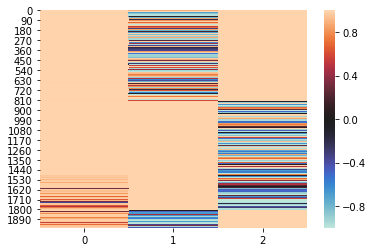

metacluster_0
activity pattern: [1 0 1]
metacluster_0 pattern_0
total seqlets: 590
Task 0 hypothetical scores:


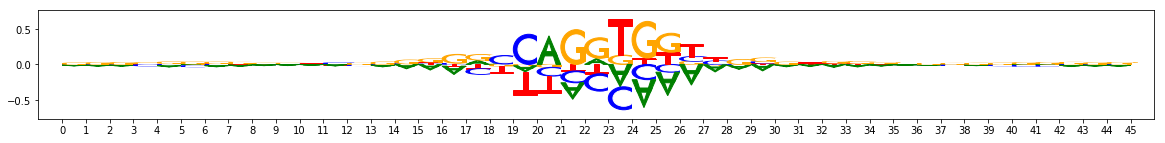

Task 0 actual importance scores:


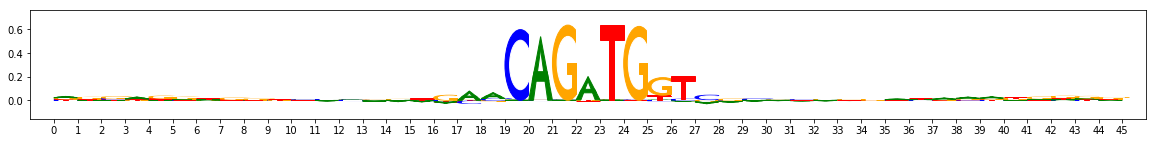

Task 1 hypothetical scores:


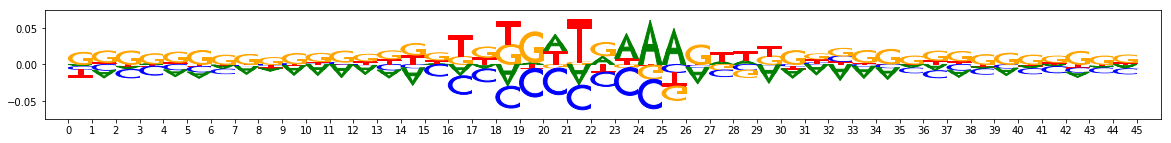

Task 1 actual importance scores:


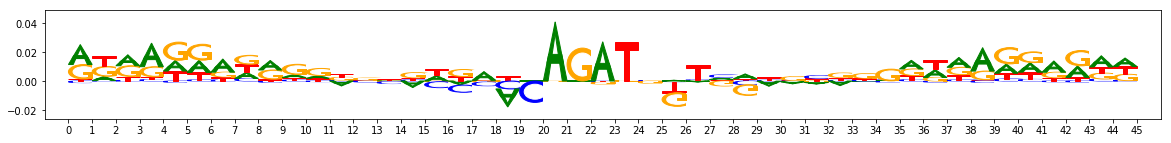

Task 2 hypothetical scores:


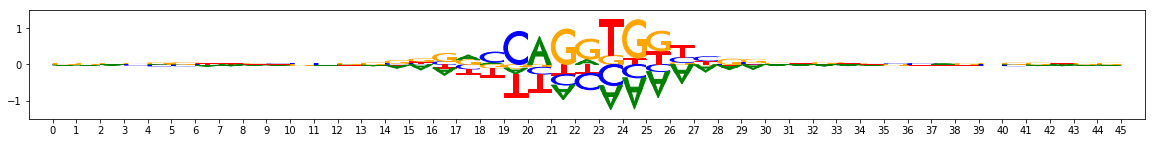

Task 2 actual importance scores:


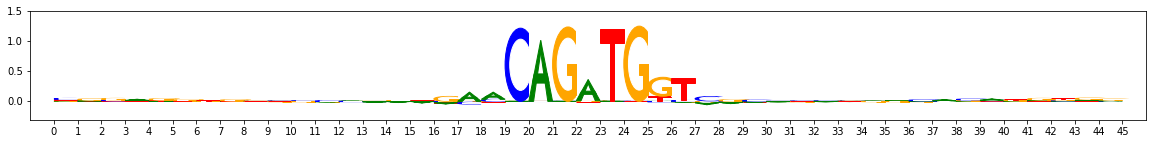

onehot, fwd and rev:


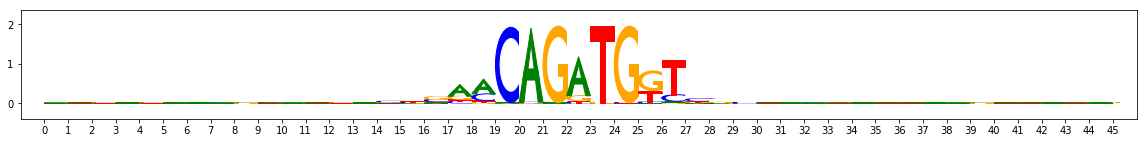

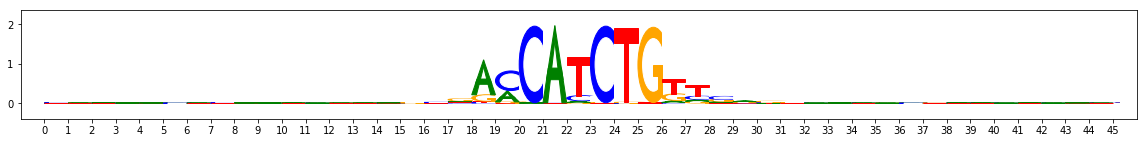

metacluster_1
activity pattern: [1 1 0]
metacluster_1 pattern_0
total seqlets: 401
Task 0 hypothetical scores:


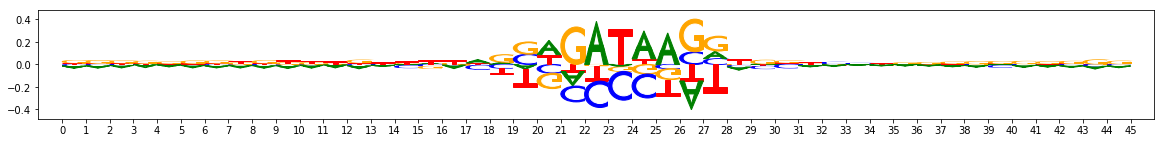

Task 0 actual importance scores:


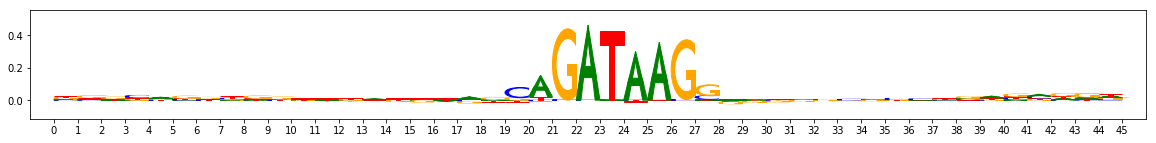

Task 1 hypothetical scores:


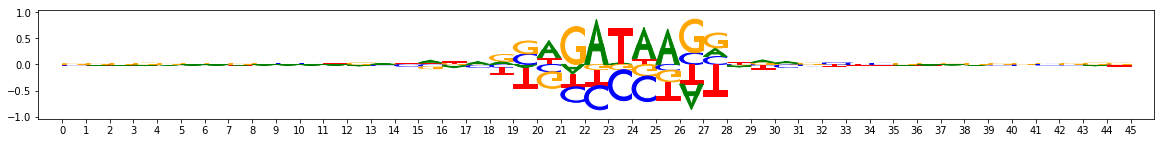

Task 1 actual importance scores:


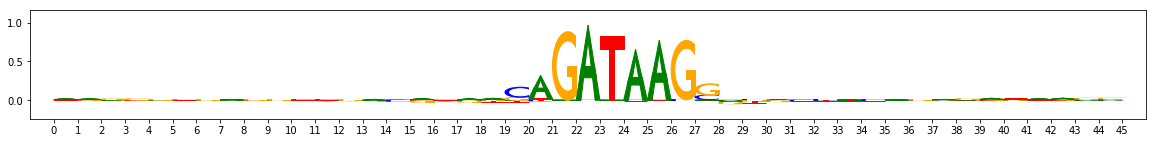

Task 2 hypothetical scores:


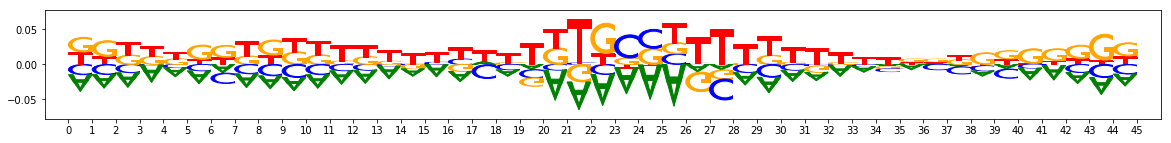

Task 2 actual importance scores:


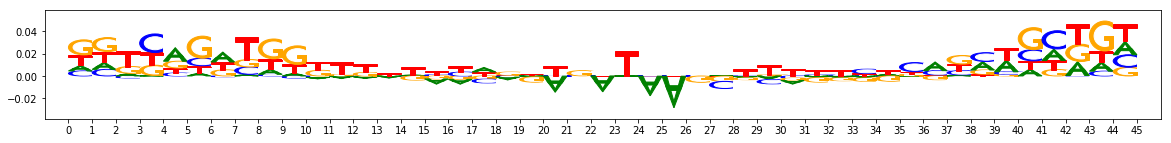

onehot, fwd and rev:


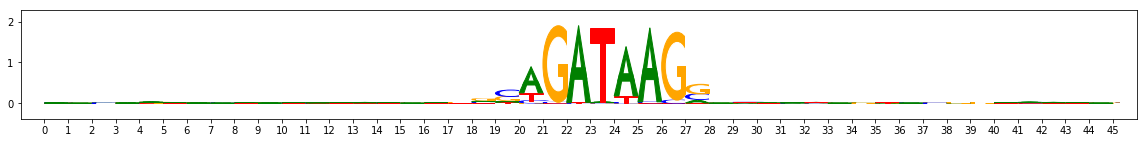

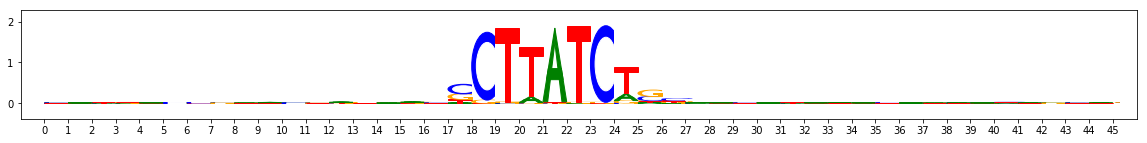

metacluster_2
activity pattern: [0 1 0]
metacluster_2 pattern_0
total seqlets: 125
Task 0 hypothetical scores:


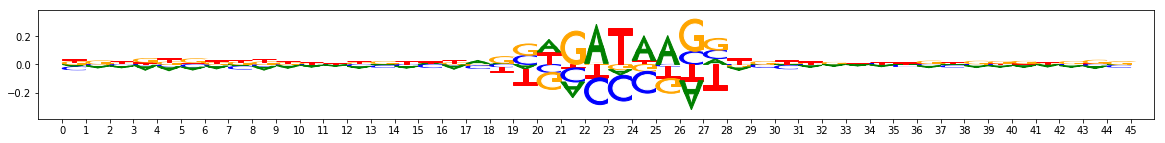

Task 0 actual importance scores:


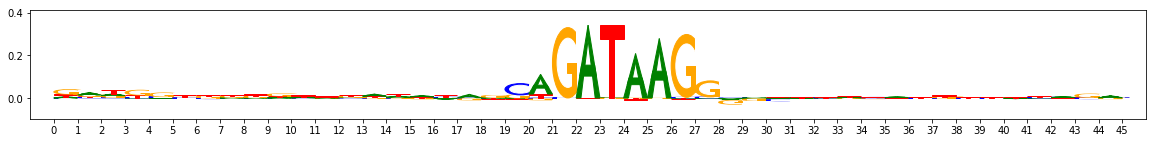

Task 1 hypothetical scores:


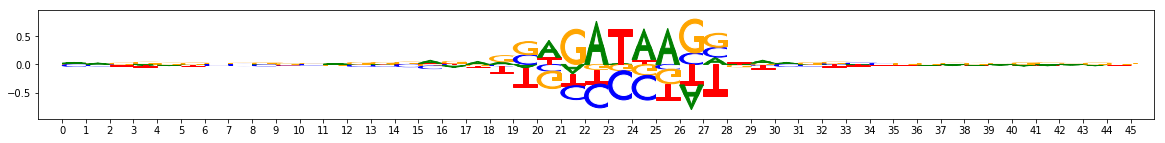

Task 1 actual importance scores:


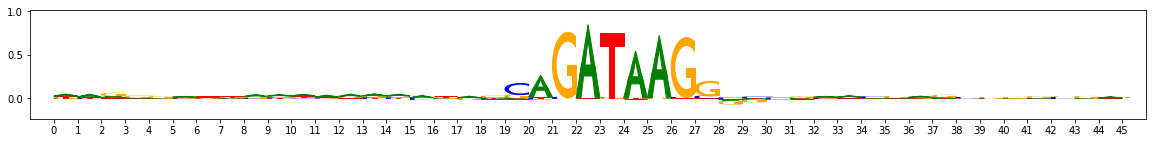

Task 2 hypothetical scores:


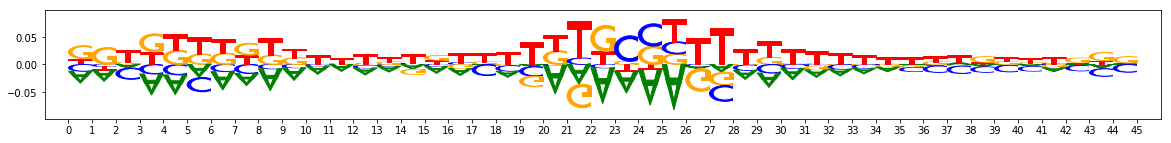

Task 2 actual importance scores:


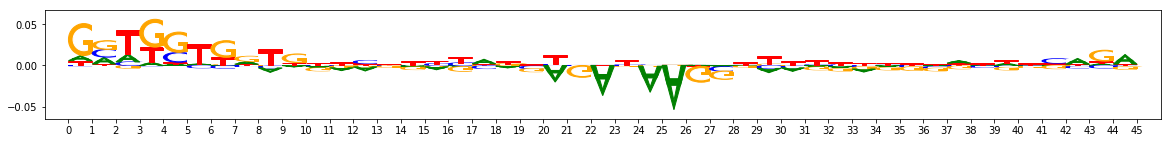

onehot, fwd and rev:


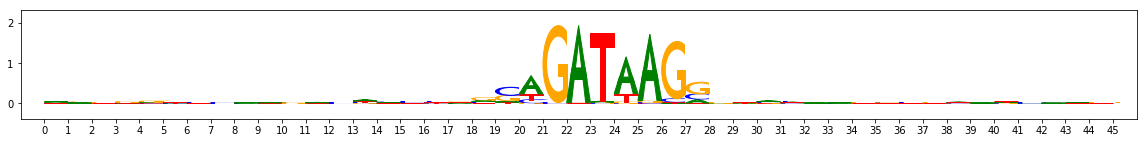

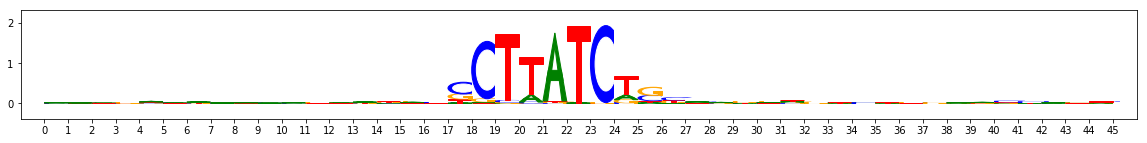

metacluster_3
activity pattern: [0 0 1]
metacluster_3 pattern_0
total seqlets: 100
Task 0 hypothetical scores:


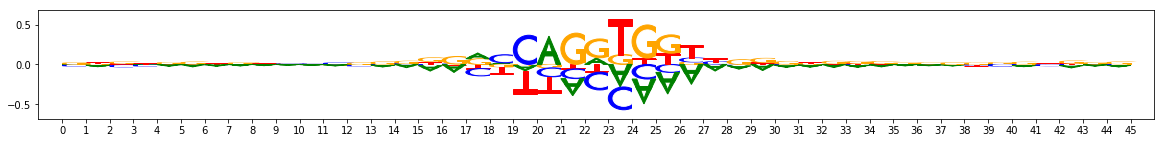

Task 0 actual importance scores:


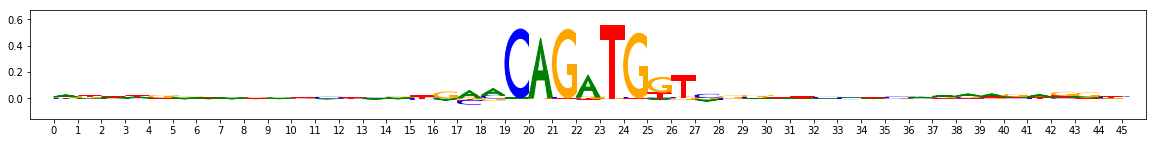

Task 1 hypothetical scores:


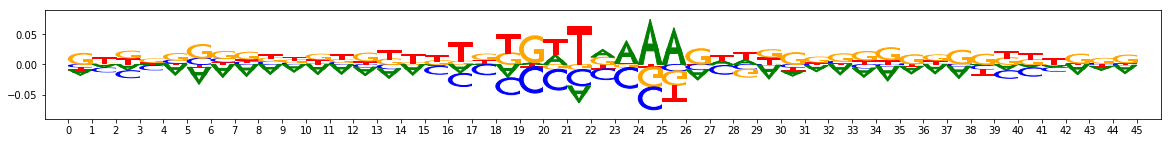

Task 1 actual importance scores:


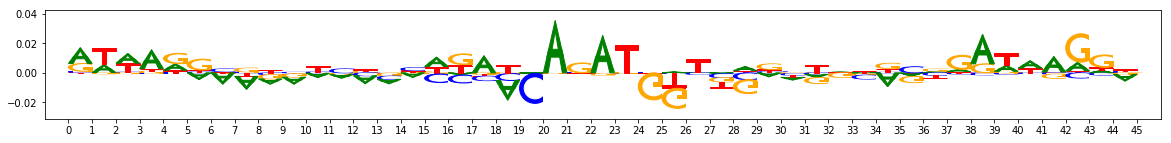

Task 2 hypothetical scores:


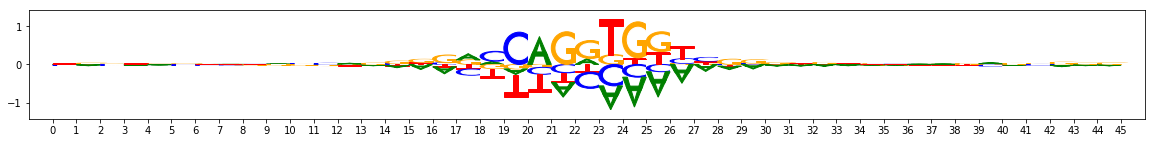

Task 2 actual importance scores:


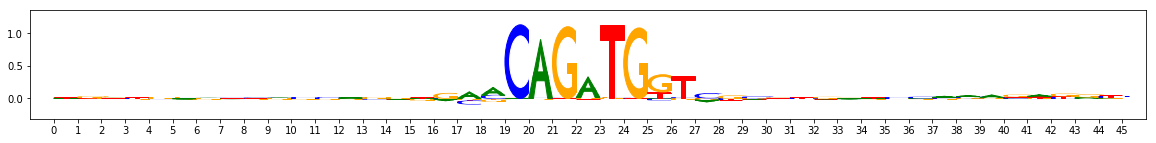

onehot, fwd and rev:


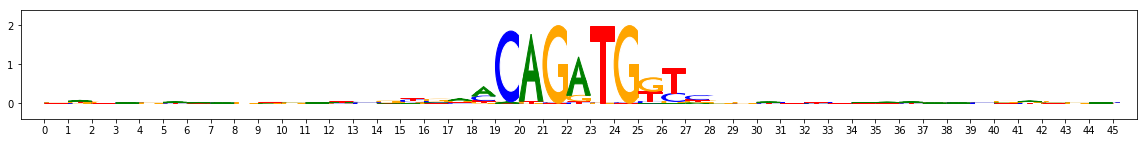

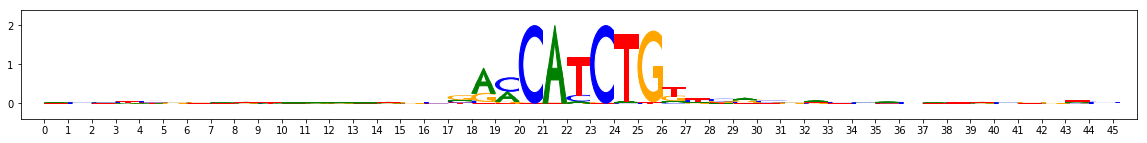

In [28]:
from collections import Counter
from modisco.visualization import viz_sequence
reload(viz_sequence)
from matplotlib import pyplot as plt

import modisco.affinitymat.core
reload(modisco.affinitymat.core)
import modisco.cluster.phenograph.core
reload(modisco.cluster.phenograph.core)
import modisco.cluster.phenograph.cluster
reload(modisco.cluster.phenograph.cluster)
import modisco.cluster.core
reload(modisco.cluster.core)
import modisco.aggregator
reload(modisco.aggregator)

hdf5_results = h5py.File("results.hdf5","r")

print("Metaclusters heatmap")
import seaborn as sns
activity_patterns = np.array(hdf5_results['metaclustering_results']['attribute_vectors'])[
                    np.array(
        [x[0] for x in sorted(
                enumerate(hdf5_results['metaclustering_results']['metacluster_indices']),
               key=lambda x: x[1])])]
sns.heatmap(activity_patterns, center=0)
plt.show()

metacluster_names = [
    x.decode("utf-8") for x in 
    list(hdf5_results["metaclustering_results"]
         ["all_metacluster_names"][:])]

all_patterns = []

for metacluster_name in metacluster_names:
    print(metacluster_name)
    metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"]
                                   [metacluster_name])
    print("activity pattern:",metacluster_grp["activity_pattern"][:])
    all_pattern_names = [x.decode("utf-8") for x in 
                         list(metacluster_grp["seqlets_to_patterns_result"]
                                             ["patterns"]["all_pattern_names"][:])]
    if (len(all_pattern_names)==0):
        print("No motifs found for this activity pattern")
    for pattern_name in all_pattern_names:
        print(metacluster_name, pattern_name)
        all_patterns.append((metacluster_name, pattern_name))
        pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
        print("total seqlets:",len(pattern["seqlets_and_alnmts"]["seqlets"]))
        background = np.array([0.27, 0.23, 0.23, 0.27])
        print("Task 0 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task0_hypothetical_contribs"]["fwd"])
        print("Task 0 actual importance scores:")
        viz_sequence.plot_weights(pattern["task0_contrib_scores"]["fwd"])
        print("Task 1 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task1_hypothetical_contribs"]["fwd"])
        print("Task 1 actual importance scores:")
        viz_sequence.plot_weights(pattern["task1_contrib_scores"]["fwd"])
        print("Task 2 hypothetical scores:")
        viz_sequence.plot_weights(pattern["task2_hypothetical_contribs"]["fwd"])
        print("Task 2 actual importance scores:")
        viz_sequence.plot_weights(pattern["task2_contrib_scores"]["fwd"])
        print("onehot, fwd and rev:")
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["fwd"]),
                                                        background=background)) 
        viz_sequence.plot_weights(viz_sequence.ic_scale(np.array(pattern["sequence"]["rev"]),
                                                        background=background)) 
        
hdf5_results.close()

## Investigate co-enrichment of motifs

TF-MoDISco identified the following motifs:
- "metacluster_0, pattern_0" is the TAL motif (CAGATG) with high importance for both task 0 and task 2
- "metacluster_3, pattern_0" is the TAL motif (CAGATG) with high importance only for task 2
- "metacluster_1, pattern_0" is the GATA motif (GATAAG) with high importance for both task 0 and task 1
- "metacluster_2, pattern_0" is the GATA motif (GATAAG) with high importance only for task 1

In the underlying simulation, a 1 for task 0 requires the presence of both the TAL motif (CAGATG) and the GATA motif (GATAAG). This is reflected in the co-enrichment patterns. We find that:
- "metacluster_0, pattern_0" (TAL motif that is high for task 0) co-occurs with "metacluster_1, pattern_0" (GATA motif that is high for task 0) more than "metacluster_2, pattern_0" (GATA motif that is not high for task 0).
- "metacluster_1, pattern_0" (GATA motif that is high for task 0) co-occurs  with "metacluster_0, pattern_0" (TAL motif that is high for task 0) more than "metacluster_3, pattern_0" (TAL motif that is not high for task 0), although the difference is not statistically significant with these sample sizes

The code to compute this is below:

In [29]:
import scipy.stats
import h5py

hdf5_results = h5py.File("results.hdf5","r")

patterns_to_compare = [
    [("metacluster_1", "pattern_0"), ("metacluster_2", "pattern_0")],
    [("metacluster_0", "pattern_0"), ("metacluster_3", "pattern_0")]
]

for ((pattern1_metacluster, pattern1_name),
     (pattern2_metacluster, pattern2_name)) in patterns_to_compare:
    
    print("Comparing "+pattern1_metacluster+"_"+pattern1_name
          +" and "+pattern2_metacluster+"_"+pattern2_name)
    
    pattern1_seqlets = list(hdf5_results["metacluster_idx_to_submetacluster_results"]\
                                             [pattern1_metacluster]["seqlets_to_patterns_result"]\
                                             ["patterns"][pattern1_name]["seqlets_and_alnmts"]["seqlets"])
    pattern1_example_idxs = set([
        x.decode("utf-8").split(",")[0].split(":")[1] for x in
        pattern1_seqlets])

    pattern2_seqlets = list(hdf5_results["metacluster_idx_to_submetacluster_results"]\
                                         [pattern2_metacluster]["seqlets_to_patterns_result"]\
                                         ["patterns"][pattern2_name]["seqlets_and_alnmts"]["seqlets"])
    pattern2_example_idxs = set([
        x.decode("utf-8").split(",")[0].split(":")[1] for x in
        pattern2_seqlets])

    for (comparison_pattern_metacluster,
         comparison_pattern_name) in all_patterns:
        
        if ((comparison_pattern_metacluster+"_"+comparison_pattern_name
             != pattern1_metacluster+"_"+pattern1_name)
            and (comparison_pattern_metacluster+"_"+comparison_pattern_name
             != pattern2_metacluster+"_"+pattern2_name)):
            
            comparison_pattern_seqlets = list(
                hdf5_results["metacluster_idx_to_submetacluster_results"]\
                [comparison_pattern_metacluster]["seqlets_to_patterns_result"]\
                ["patterns"][comparison_pattern_name]["seqlets_and_alnmts"]["seqlets"])
            comparison_pattern_example_idxs = set([
                x.decode("utf-8").split(",")[0].split(":")[1] for x in
                comparison_pattern_seqlets])
        
            
            pattern1_overlap = len(pattern1_example_idxs.intersection(
                                    comparison_pattern_example_idxs))
            pattern2_overlap = len(pattern2_example_idxs.intersection(
                                    comparison_pattern_example_idxs))
            
            contingency_table = np.array([
                [pattern1_overlap, len(pattern1_example_idxs)-pattern1_overlap],
                [pattern2_overlap, len(pattern2_example_idxs)-pattern2_overlap]])
            odds_ratio, p_value = scipy.stats.fisher_exact(contingency_table)
            if (p_value < 0.25):
                print("Looking at enrichment for "+comparison_pattern_metacluster
                                              +"_"+comparison_pattern_name)
                print("Odds ratio:",odds_ratio,
                      "P-value:",p_value)

            
hdf5_results.close()

Comparing metacluster_1_pattern_0 and metacluster_2_pattern_0
Looking at enrichment for metacluster_0_pattern_0
Odds ratio: 1.5588194921070693 P-value: 0.05040081095112875
Looking at enrichment for metacluster_3_pattern_0
Odds ratio: 1.79806598407281 P-value: 0.23413126762814707
Comparing metacluster_0_pattern_0 and metacluster_3_pattern_0
Looking at enrichment for metacluster_1_pattern_0
Odds ratio: 1.5943288686235395 P-value: 0.06258230344596698
Looking at enrichment for metacluster_2_pattern_0
Odds ratio: 1.9475138121546962 P-value: 0.14326916721933558
